Note: aggiungere una colonna al dataset per la lunghezza dei messaggi, la lunghezza dei messaggi è correlata alla label, controllare se il trend si conferma anche nei dati aumentati. Questo dato verrà passato al classificatore insieme agli embeddings




TODO:
- Referenze classi  [github](https://github.com/fredffsixty/Natural_Language_Processing/blob/main/Esercitazioni/E6.%20BERT/Esercitazione6b.ipynb)
- Sistemare datagenerator
- Preparare script da far andare per la generazione del dataset aumentato (salvare sia il dataset pulito che i dati grezzi per sicurezza)
- Adattarlo anche al secondo dataset
- Preparare classificatore (dimensione dell'ultimo layer dinamica, da prendere in base al numero di label)
- preparare funzione per ottenere un dizionario con le chiavi in modo da tradurre parole in numeri

Task

Subtask A: Conspiratorial Content Classification: A system must recognize if a telegram
post is conspiratorial or not.

A sentence is Conspiratorial if either  
(i) expresses the belief that major events(e.g., covid) are manipulation created by powerful people to protect their interests  
 or  
(ii) an interpretation of events meant to contribute to strengthening the underlying narrative of the conspiracy theory.

A sentence is Not Conspiratorial if it does not diffuse any kind of beliefs linked to the conspiracy theory.

Definizione della teoria del complotto

Una teoria del complotto o della cospirazione (talvolta nella forma aggettivale: teoria complottista o cospirativa) è una teoria o spiegazione di un evento o una situazione, spesso alimentata da motivazioni politiche, che ne attribuisce cause e responsabilità a una cospirazione ordita da gruppi elitari e potenti (spesso detti «poteri forti»), nonostante le altre spiegazioni già fornite siano più plausibili e affidabili. Il termine ha una connotazione negativa, poiché implica che il credere a tali teorie sia una pratica basata sul mero pregiudizio e su prove insufficienti. Una «teoria del complotto» non è la stessa cosa di una cospirazione; perché si riferisce a una cospirazione ipotizzata con caratteristiche specifiche, come un'opposizione al consenso tradizionale (talvolta detto «mainstream») tra quelle persone, come scienziati o storici, che sono qualificate per valutarne l'accuratezza.

Le teorie del complotto sono restie alle critiche e al principio di falsificabilità; al contrario trovano forza nella logica circolare: sia le prove che confutano il complotto che l'assenza di prove a favore della sua esistenza sono reinterpretate dai complottisti come indiscutibili dimostrazioni della sua verità, per cui la cospirazione diventa una questione di fede piuttosto che qualcosa che può essere provato o confutato. La ricerca suggerisce che l'ideologia complottista—la fede nelle teorie del complotto—può essere psicologicamente dannosa o patologica e che è correlata a scarso pensiero analitico, basso quoziente d'intelligenza, proiezione psicologica, paranoia e machiavellismo. Gli psicologi attribuiscono il trovare teorie del complotto lì dove non ce ne sono a un fenomeno mentale chiamato «apofenia».

[Fonte](https://it.wikipedia.org/wiki/Teoria_del_complotto)

In [1]:
!pip install scikit-learn pandas numpy nltk transformers torch matplotlib seaborn python-dotenv

Documentazioni:  
Hugchat: https://pypi.org/project/hugchat/


Il dataset presenta una lista di messaggi/post raccolti su vari social, una delle caratteristiche di queste forme di comunicazioni sono le emoticon (o emoji) e la forma del messaggio in se.
Questo significa che un testo che vuole catturare l'attenzione avrà un "titolo" d'impatto e spesso in maiuscolo, in quanto l'attenzione dedicata a questo tipo di contenuti è poca e di carattere transitorio.

Inoltre il dataset presenta una quantità di dati inadatta all'addestramento di un qualsiasi classficatore superabile tramite tecniche di data augmentation, questa caratteristica è intriseca nel problema in quanto i trend [^1] durano molto poco nel tempo e per un sistema di riconoscimento dei contenuti fuorvianti è necessario essere in grado di adattarsi in breve a queste variazioni.

Il dataset ha dimensione eterogenea, il che potrebbe portare a esempi per il transformer dove sono presenti lunghe stringhe di filler.


Di seguito verranno proposte alcune tecniche di preprocessing e di data augmentation


[^1]: Per trend si indica un argomento che cattura l'attenzione del pubblico e che ha orizzonte temporale molto breve, di solito nell'ordine dei giorni.

Possibili tentativi  

Data augmentation
- prendere solo i caratteri ripetuti o parole maiuscole e emoticon dal testo e verificare la label, questo può funzionare in quanto spesso la comunicazione passa per l'impatto della forma  

- utilizzare altri modelli di elaborazione del linguaggio, chiedendo di modificare il testo mantenendone il significato, nascondendone parti o riformulare in modo più o meno aggressivo la frase


Data preprocessing  

- Raccolta di una percentuale della frase per raccogliere il "titolo" 

In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import time
from torch.optim import Adam
from torch import nn
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.utils import shuffle
import nltk
import matplotlib.pyplot as plt

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
pd.set_option('display.max_colwidth', None)
dataset = pd.read_csv('Dataset/subtaskA_train.csv',  header=0, names=['id', 'text', 'label'])
color1 = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 
color2 = (0.4, # redness
         0.2, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 


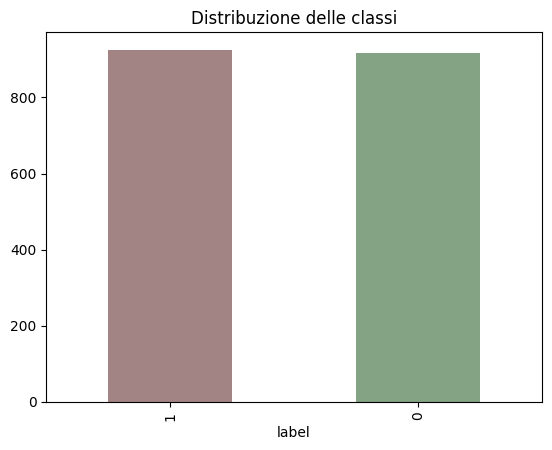

In [6]:
dataset['label'].value_counts().plot(kind='bar', color=[color2,color1])
plt.title('Distribuzione delle classi')
plt.show()


In [4]:
print("dati mancanti")
print(dataset.isna().sum())

dati mancanti
id       0
text     0
label    0
dtype: int64


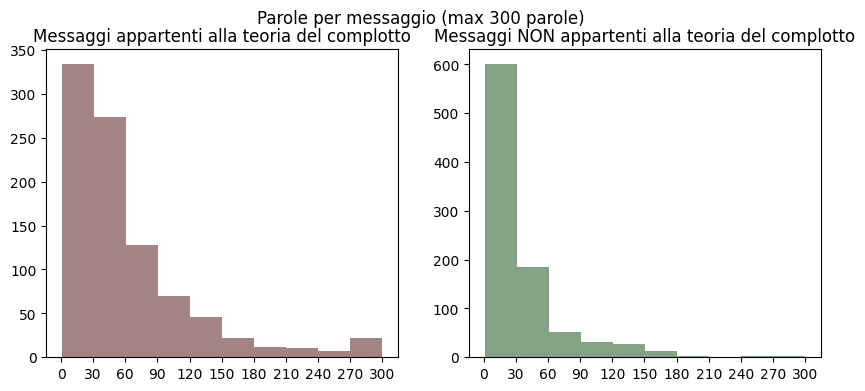

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
ax1.set_xticks([0,30,60,90,120,150,180,210,240,270,300])
ax2.set_xticks([0,30,60,90,120,150,180,210,240,270,300])
dataset_words=dataset[dataset['label']==1]['text'].str.split().map(lambda x: len(x) if len(x)<300 else 300)
ax1.hist(dataset_words,color=color2)
ax1.set_title('Messaggi appartenti alla teoria del complotto')
dataset_words=dataset[dataset['label']==0]['text'].str.split().map(lambda x: len(x) if len(x)<300 else 300)
ax2.hist(dataset_words,color=color1)
ax2.set_title('Messaggi NON appartenti alla teoria del complotto')
fig.suptitle('Parole per messaggio (max 300 parole)')
plt.show()

Da questo grafico notiamo che i messaggi più lunghi di un ottantina di caratteri sono quasi certamente appartenenti alla teoria del complotto, questo comportamento può indicare che la lunghezza dei messaggi può essere utile alla classificazione, sarà necessario verificare se la tendenza è presente anche nel dataset aumentato.

Per aumentare i dati utilizziamo un chatbot che si interfaccia con [huggingface](https://huggingface.co/chat/) per ottenere l'aumento dei dati, di seguito sono mostrati i prompt provati e quale è stato infine scelto per il compito.

In [9]:
'''
from hugchat import hugchat
from hugchat.login import Login
from dotenv import load_dotenv


load_dotenv()

email = os.getenv("EMAIL_HF")
passwd = os.getenv("PASS_HF")

 
# Log in to huggingface and grant authorization to huggingchat
sign = Login(email, passwd)
cookies = sign.login()

# Save cookies to the local directory
cookie_path_dir = "./cookies_snapshot"
sign.saveCookiesToDir(cookie_path_dir)
'''


' \n# Log in to huggingface and grant authorization to huggingchat\nsign = Login(email, passwd)\ncookies = sign.login()\n\n# Save cookies to the local directory\ncookie_path_dir = "./cookies_snapshot"\nsign.saveCookiesToDir(cookie_path_dir)\n'

I modelli disponibili sono i seguenti, è possibile cambiare cambiare modello con _chatbot.switch_llm(index)_

In [10]:
'''

cookie_path_dir = "./cookies_snapshot"
sign = Login(email, None)
cookies = sign.loadCookiesFromDir(cookie_path_dir)
chatbot = hugchat.ChatBot(cookies=cookies.get_dict())  
models = chatbot.get_available_llm_models()
active_model = chatbot.switch_llm(4)
id = chatbot.new_conversation()
chatbot.change_conversation(id)
print("Modelli disponibili:")
for m in range(len(models)):
    print(models[m])

'''

Modelli disponibili:
meta-llama/Llama-2-70b-chat-hf
codellama/CodeLlama-34b-Instruct-hf
tiiuae/falcon-180B-chat
mistralai/Mistral-7B-Instruct-v0.1
openchat/openchat_3.5


Prompt testati:

1 - "Sei un sistema per fare data augmentation per un task NLP che deve classificare se un testo è  cospirazionista o no, ti verrà fornita una coppia di valori testo-label e dovrai generare nuove righe di dati. I dati generati avranno lo stesso significato di quelli inviati ma con parole diverse. Genererai 4 righe per ogni input di cui: una con lo stesso significato e tono, una riassunta, una con lo stesso significato ed un tono più aggressivo ed  una con lo stesso significato ed un tono più amichevole. I dati forniti sono nella forma text, label,  la label è un valore booleano che indica se il testo è cospirazionista o meno. La label deve essere coerente con il contenuto del testo generato. La lingua del risultato deve essere italiano"

Estrazione del testo: 
'''
import re
def estrai_testo_label(testo):
    
    testo_pattern = r'Testo: "(.*?)"'  
    label_pattern = r'Label: (\d)'  
    riepilogo_pattern = r'Riepilogo: "(.*?)"'  
    riassunto_pattern = r'Riassunto: "(.*?)"'  
    testi = re.findall(testo_pattern, testo)  
    labels = re.findall(label_pattern, testo)  
    riepilogo = re.findall(riepilogo_pattern, testo)  
    riassunto = re.findall(riassunto_pattern, testo)  
    if len(riepilogo) == 0:  
        testi.insert(1, riassunto[0])  
    else:  
        testi.insert(1, riepilogo[0])  
 
    testi_no_contorno = []  
    labels_no_contorno = []  
    
    for i in range(len(testi)):  
        a = testi[i].split(':')  
        b = labels[i].split(':')  
        testi_no_contorno.append(a)  
        labels_no_contorno.append(b)  
    
    return testi_no_contorno, labels_no_contorno  
'''

2 - '
    Input:  
    "Testo originale: {dataset.loc[i,['text']].to_string()}"  

    Output desiderato:  
 
    "Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato."  
    "Fornisci un riassunto del testo originale."  
    "Sostituisci alcune parole chiave nel testo originale."  
    "Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato ed in lingua italiana."  
    "Trasforma il testo originale in una domanda diretta."  
    
    Tutti gli output devono essere in italiano  
    '
Estrazione del testo:  
'''  
def get_text_clean(text):  
    true_list = [2,4,6,8,10]  
    text = text.split("\n")   
    text_array = [line for line in text if line.strip() != ""]  
    text_array = [i for i in text_array if text_array.index(i) in true_list]  
    return text_array  
'''


Il secondo prompt si è dimostrato più consistente e preciso nelle risposte, per cui viene utilizzato per aumentare il dataset

In [11]:
##Dataset di prova per testare il funzionamento dell'augmenter
df_test = dataset[:5].copy()
df_test['text'] = df_test['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
df_test.head()


,id,text,label
0,0,⚡Se non ci fossero soldati non ci sarebbero guerre.,0
1,1,"21/08/21]( [PRE-PRINT] 📄__ ""Shedding of Infectious SARS-CoV-2 Despite Vaccination"" 🇮🇹 ""Diffusione del SARS-CoV-2 nonostante la vaccinazione""__ 📊 ""La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale. [...] le indagini sull'epidemia suggeriscono che le persone vaccinate possono diffondere [la variante] Delta"" ⚠️ ""[...] questi risultati indicano che anche le **persone asintomatiche e comple vaccinate possono diffondere il virus infettivo**."" ⚠️ ""[...] questi dati indicano che gli individui **vaccinati e non vaccinati** infettati dalla variante Delta **possono trasmettere l'infezione**."" 📚 **",1
2,2,"PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA VERITA' La scorsa settimana Elon Musk ha dichiarato di volere che la ""libertà di parola"" sui social media sia tutelata ai sensi della Legge del Paese. I DEM sono spaventatissimi dalla scelta coraggiosa del magnate dello Spazio di acquistare Twitter così scontrandosi frontalmente, e senza paura, con BlackRock, Vanguard e State Street, cioè i tre fondi di inves che controllano il 95% delle multinazionali tra le prime 500 al Mondo. I DEM americani hanno risposto con la grande sorella Hillary e il grande fratello Obama, i quali twittando hanno ordinato di allestire opportuni apparati di censura, una comanda ovviamente presa dai loro camerieri della UE e della ridicola Amministrazione Biden. Si tratta di un disperato tentativo di nascondere le Verità che stanno emergendo sul Covid19 e i vaccini, i supposti morti 'senza correlazione', le elezioni americane e francesi colossalmente truccate, i ladrocini finanziari trilionari con i derivati, i sacrifici umani e soprattutto di bambini e tante altre rivelazioni usando un ""Ministero della Verità"" in perfetto stile Orwell 1984. Questa risposta DEM è assolu incostituzionale e non basta chiamare questi abomini 'Board per la Disinformazione' (in America) o 'Piattaforma per la Disinformazione' (in Unione Europea) per giustificare il tentativo di nascondere la Verità agli occhi della gente, tentando di non sembrare quello che sempre più palesemente si è: Tiranni Globali come quelli descritti in tutta la Letteratura distopica. Ricordo che Twitter aveva censurato la Verità sul laptop di Hunter Biden poco prima delle elezioni del 2020, e se ciò non fosse stato fatto e i media avessero fatto il loro lavoro, tutti sapremmo dei traffici di esseri umani ed energetici all'ombra di BURISMA, la compagnia del gas Ucraino nel cui board sedeva il figlio di Joe Biden dopo il colpo di stato del 2014, per il fine di realizzare in Ucraina quella base della piattaforma del Male oggi usata per alimentare la possibilità di una Terza Guerra Mondiale Nucleare. Le cose stanno precipitando per i DEM con la prospettiva di ricongiungerli ai loro DEMoni ispiratori. In questo senso è al simbolica l'uscita dell'analista politico della CNN David Zurawik di ieri, quando ha detto che è molto pericolosa l'acquisizione di Twitter da parte di Elon Musk, e che l'America deve guardare all'Europa per le risposte. In preda ad un sen di paura e delirio come quello del letterato iconico dei democratici americani, il drogato di adrenocromo Hunter Thompson nel suo famoso romanzo autobiografico ""Paura e Delirio al Las Vegas"", l'opinionista della CNN ha dichiarato: ""Hai bisogno di regolamentazione. Non puoi lasciare che questi ragazzi controllino la narrazione in questo paese o saremo diretti all'inferno. Noi ci siamo. Trump ha aperto le porte dell'inferno e ora ci stanno inseguendo"". Sono d'accordo con David Zurawik ma nel senso che le porte dell'Inferno sono effettivamente spalancate e pronte ad accogliere i meritevoli. Tutti gli esseri umani corrotti dal potere, dalla fama e dal denaro che sono stati strumenti del maligno, avranno il loro posto meritato. Nove, Nove, Nove. P.S. Godetevi il video con la 

In [12]:
def get_prompt_list(dataframe):
    prompt_list = []
    for i in range(len(dataframe)):
        prompt_list.append(f"""
        Input:
        "Testo originale: '''{dataframe.loc[i,['text']].to_string()}'''"

        Output desiderato:

        "Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato in italiano."
        "Fornisci un riassunto del testo originale in italiano."
        "Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato in italiano."
        "Sostituisci alcune parole chiave nel testo originale in italiano."
        "Trasforma il testo originale in una domanda diretta in italiano."
        
        Richiesta di risposta (formato predefinito):
        "Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

        [Sinonimi]: [Testo risultante sostituendo le parole chiave con dei sinonimi]
        [Riassunto]: [Riassunto risultante]
        [Tono diverso]: [Testo risultante con tono diverso]
        [Parole chiave sostituite]: [Testo risultante con parole chiave sostituite]
        [Domanda diretta]: [Testo risultante come domanda diretta]"


    """)

    return prompt_list

In [13]:
def get_clean_text(text):
    result = []
    lines = text.split("\n")
    for line in lines:
        if ":" in line:
            start_index = line.index(":") + 1
            result.append(line[start_index:])
    return result

def get_augmented_dataset(array_of_text, original_data, label):
    augmented_dataset = pd.DataFrame(columns=['text', 'label'])
    df = pd.DataFrame(columns=['text', 'label'])
    augmented_dataset.loc[0]= [original_data, label]
    for i in range(len(array_of_text)):
        df.loc[0]= [array_of_text[i], label]
        augmented_dataset = pd.concat([augmented_dataset,df], ignore_index=True)
    return augmented_dataset


In [19]:
''' 
prompt_list = get_prompt_list(df_test)
augmented_dataset = pd.DataFrame(columns=['text', 'label'])

for i in range(len(prompt_list)):
    query_result = chatbot.query(prompt_list[i])
    print(query_result['text'])
    text_array = get_clean_text(query_result['text'])
    augmented_dataset = pd.concat([augmented_dataset,get_augmented_dataset(text_array, df_test.at[df_test.index[i],'text'], df_test.at[df_test.index[i],'label'])],ignore_index=True)
    #timeout per evitare di essere bannati
    time.sleep(5)
augmented_dataset['text'] = augmented_dataset['text'].apply(lambda x: x.replace('```testo modificato:`', ' ').replace('`testo originale:`', ' ')).replace('```testo alternativo:``',' ' )
print(augmented_dataset)
'''

_getitem_
done
 Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

[Sinonimi]: ````testo originale:`` Se non ci fossero soldati, non ci sarebbero mai state guerre'';
[Riassunto]: Soldati e guerra sono strettamente legati.
[Tono diverso]: Se non esistesse l'esercito, le battaglie non sarebbero mai avvenute.
[Parole chiave sostituite]: ```testo alternativo:`` Assenti gli ufficiali, mancava la lotta.'';
[Domanda diretta]: Come è collegata la presenza di soldati alla nascita delle guerre?
_getitem_
done
_getitem_
done
 Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

[Sinonimi]: ``21/08/21` (Preprint) 📄 __“Liberazione del Virus SARS-CoV-2 nonostante la Vaccinazione”___ 🇮🇹 “Dispersione del SARS-CoV-2 anche a seguito della Somministrazione”__ 📊 “La Variante Delta del SARS-CoV-2 può produrre Alte Cariche Virali, è Trasportabile e contiene Mutazioni 

In [20]:
'''
prompt_list = get_prompt_list(df_test)
augmented_dataset = pd.DataFrame(columns=['text', 'label', 'augmented_text'])

for i in range(len(prompt_list)):
    query_result = chatbot.query(prompt_list[i])
    print(query_result['text'])
    augmented_dataset.loc[i,'text'] = dataset.loc[i,'text']
    augmented_dataset.loc[i,'label'] = dataset.loc[i,'label']
    augmented_dataset.loc[i,'augmented_text'] = query_result['text']
    #timeout per evitare di essere bannati
    time.sleep(5)
print(augmented_dataset)
'''

_getitem_
done
 Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

[Sinonimi]: "Se non c'era l'esercito, non ci sarebbero state guerre." "Assenti gli ufficiali militari, non ci sarebbero mai stati combattimenti." "Se nessuno portava armi, non ci sarebbe stata mai guerra."
[Riassunto]: Se non ci fossero soldati, non ci sarebbero guerre.
[Tono diverso]: Assenti gli ufficiali militari, non ci sarebbero mai stati combattimenti.
[Parole chiave sostituite]: "'''text    ⚡Se non ci fosse l'esercito, non ci sarebbero guerre.'''"
[Domanda diretta]: Se non ci fossero soldati, ci sarebbe ancora guerra?
_getitem_
done
_getitem_
done
 Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

[Sinonimi]: "Il 21 agosto 2021]( [PRE-DRAFT]    📄__ "Distacco di Infezioso SARS-CoV-2 Malgrado la Vaccinazione"  🇮🇹 "Propagazione del SARS-CoV-2 Nonostante la Vaccinazione"__  

In [72]:
'''
prompt_list = get_prompt_list(dataset)

augmented_dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(prompt_list)):
    query_result = chatbot.query(prompt_list[i])
    #print(query_result['text'])
    text_array = get_text_clean(query_result['text'])
    augmented_dataset = pd.concat([augmented_dataset,get_augmented_dataset(text_array, df_test.at[df_test.index[i],'text'], df_test.at[df_test.index[i],'label'])],ignore_index=True)
    #timeout per evitare di essere bannati
    time.sleep(5)
augmented_dataset.head()
augmented_dataset = shuffle(augmented_dataset)
augmented_dataset.to_csv('Dataset/augmented_dataset.csv', index=False)
'''

_getitem_
done
_getitem_
done
_getitem_
done
_getitem_
done
_getitem_
done


,text,label
0,⚡Se non ci fossero soldati non ci sarebbero guerre.,0
1,"""Se non ci fossoro combattenti non ci sarebbero conflitti.""",0
2,"""Il testo afferma che l'esistenza di soldati è necessaria per la guerra.""",0
3,"""Se non ci fossoro militi non ci sarebbero battaglie.""",0
4,"""Ah, la pace potrebbe finally arrivare se non ci fossoro quei maledetti soldati!""",0


In [7]:
def process_data_augmentation(dataset):
    typeA=['[Sinonimi]:','[Riassunto]:','[Tono diverso]:','[Parole chiave sostituite]:','[Domanda diretta]:']
    typeB=['Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato in italiano:','Fornisci un riassunto del testo originale in italiano:','Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato in italiano:', 'Sostituisci alcune parole chiave nel testo originale in italiano:','Trasforma il testo originale in una domanda diretta in italiano:']
    processed_dataset = pd.DataFrame(columns=['text', 'label'])
    augmented_dataset = pd.DataFrame(columns=['text', 'label'])
    #dataset['augmented_text'] = dataset['augmented_text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

    for i in tqdm(range(len(dataset))):
        augmented = dataset.loc[i,'augmented_text']
        augmented = augmented.split('\n')

        for statement in augmented:
            for start in typeA:
                if start in statement:
                    augmented_dataset.loc[0,'text'] = statement.replace(start, '')
                    augmented_dataset.loc[0,'label'] = dataset.loc[i,'label']
                    processed_dataset = pd.concat([processed_dataset,augmented_dataset],ignore_index=True)
            for start in typeB:
                if start in statement:
                    augmented_dataset.loc[0,'text'] = statement.replace(start, '')
                    augmented_dataset.loc[0,'label'] = dataset.loc[i,'label']
                    processed_dataset = pd.concat([processed_dataset,augmented_dataset],ignore_index=True)

    return processed_dataset


In [8]:
augmented_dataset = pd.read_csv('Dataset/augmented_dataset1.csv',  header=0, names=['text', 'label','augmented_text'])

augmented_dataset = process_data_augmentation(augmented_dataset)

100%|██████████| 1842/1842 [00:04<00:00, 374.73it/s]


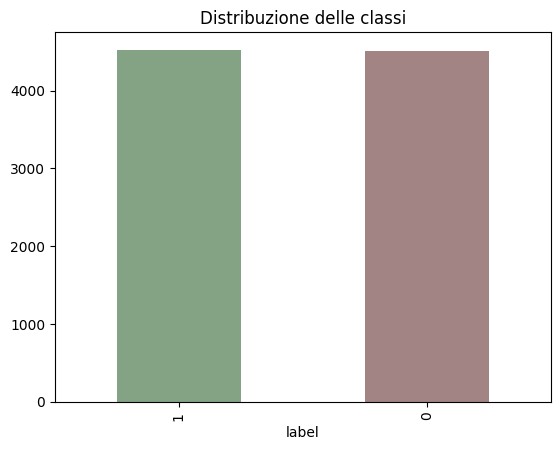

In [27]:
augmented_dataset['label'].value_counts().plot(kind='bar', color=[color1,color2])
plt.title('Distribuzione delle classi')
plt.show()

In [28]:
print("dati mancanti")
print(augmented_dataset.isna().sum())

dati mancanti
text     0
label    0
dtype: int64


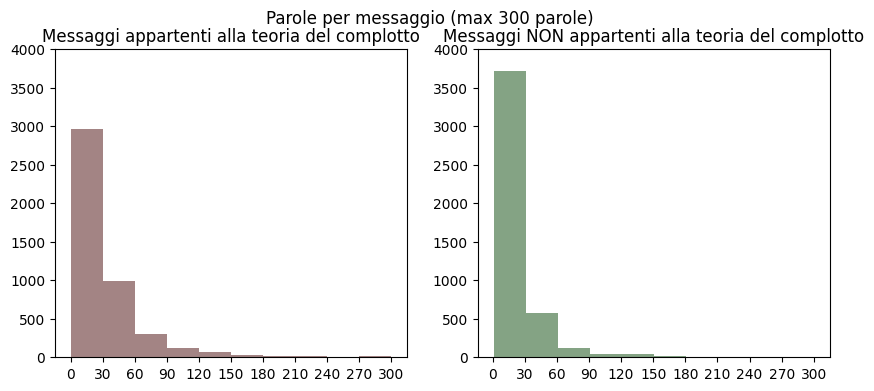

In [32]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
ax1.set_xticks([0,30,60,90,120,150,180,210,240,270,300])
ax1.set_ylim([0,4000])
ax2.set_xticks([0,30,60,90,120,150,180,210,240,270,300])
ax2.set_ylim([0,4000])
dataset_words=augmented_dataset[augmented_dataset['label']==1]['text'].str.split().map(lambda x: len(x) if len(x)<300 else 300)
ax1.hist(dataset_words,color=color2)
ax1.set_title('Messaggi appartenti alla teoria del complotto')
dataset_words=augmented_dataset[augmented_dataset['label']==0]['text'].str.split().map(lambda x: len(x) if len(x)<300 else 300)
ax2.hist(dataset_words,color=color1)
ax2.set_title('Messaggi NON appartenti alla teoria del complotto')
fig.suptitle('Parole per messaggio (max 300 parole)')
plt.show()

Dai dati rilevati e mostrati sopra, possiamo osservare come si sia mantenuta la relazione, seppur appiattita, del maggior numero di caratteri per i messaggi appartenti alla teoria del complotto, viene quindi integrata la colonna che include i caratteri del testo

In [9]:
augmented_dataset['char_count'] = augmented_dataset['text'].str.len()
augmented_dataset.head()

,text,label,char_count
0,Se non ci fossero militari non vi sarebbero conflitti armati.\r,0,64
1,Il testo afferma che l'assenza di soldati porterebbe alla scomparsa delle guerre.\r,0,83
2,"Immaginate un mondo privo di combattenti: ecco, sarebbe un mondo senza più guerre.\r",0,84
3,Supponiamo che non esistano più persone addestrate al combattimento: ciò implicherebbe la fine di ogni guerra.\r,0,112
4,Cosa succederebbe se non ci fossero più soldati?,0,49


In [10]:
augmented_dataset = shuffle(augmented_dataset)
augmented_dataset.head()

,text,label,char_count
6793,'''Azzolina diminuisce il peso delle scuole nel diffondersi dell'epidemia'''\r,0,78
2204,Prezzi alimentari globali aumentati del 60% dal 2020. **Secondo ONU**.\r,0,72
4136,Con una cooperazione di forze e unità...\r,1,42
3431,Testo risultante con parole sostituite.\r,1,41
3147,"Matteo Graci a Bologna durante la dimostrazione del 22, per coloro che non sono riusciti ad arrivare. Un intervento pieno di passione e umanità, dove emerge la rabbia per la ricerca di risposte e di verità che ci viene negata.\r",1,228


Definizione del preprocessing

Definizione del data augmentation

Definizione pipeline

In [11]:
hyperparameters = {
    "#_classes" : 2,
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.1,
    "stopwords": False,
    "h_dim": 768,
    "patience": 5,
    "min_delta": 0.01,
    "language_model": "bert-base-uncased",
}

In [12]:
(x_train, x_test,char_count_train,char_count_test, y_train, y_test) = train_test_split(augmented_dataset['text'],augmented_dataset['char_count'], augmented_dataset['label'], test_size=0.2, random_state=17)

(x_train, x_val,char_count_train,char_count_val, y_train, y_val) = train_test_split( x_train,char_count_train, y_train, test_size=0.1, random_state=42)

In [13]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, char_count, y, stopwords):

        
        tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]
        text_clean = []
        for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
            text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("italian")]))
        self.texts = [text for text in text_clean]
        self.labels = [torch.tensor(label) for label in y]
        self.char_count = [torch.tensor(char_count) for char_count in char_count]

    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def get_batch_char_count(self, idx):
        # Fetch a batch of inputs
        return self.char_count[idx]
    
    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)
        batch_char_count = self.get_batch_char_count(idx)

        return batch_texts, batch_labels, batch_char_count

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [14]:
train_dataset = Dataset(x_train, char_count_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val,char_count_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, char_count_test, y_test, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 1809/1809 [00:56<00:00, 31.89it/s]


In [15]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping
        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza

In [16]:
class ClassifierDeep(nn.Module):

    def __init__(self, labels, hdim, dropout, model_name):
        super(ClassifierDeep, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name, config=config)
        self.classifier = nn.Sequential(
            nn.Linear(hdim+1, hdim),
            nn.BatchNorm1d(hdim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hdim, labels),
            )

    def forward(self, input_id_text, attention_mask, char_count):
        output = self.lm_model(input_id_text, attention_mask).last_hidden_state
        output = output[:,0,:]
        output = torch.cat((output, char_count.unsqueeze(-1)), dim=1)  # Concatena il conteggio dei caratteri
        return self.classifier(output)

In [17]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels, batch_char_count in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()
        tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 512, truncation=True)
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
        batch_char_count = batch_char_count.to(device)
        batch_labels = batch_labels.to(device)
        batch_char_count = batch_char_count.to(device)
        output = model(input_id_texts, mask_texts,batch_char_count)


        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()
        batch_char_count = batch_char_count.detach().cpu()


    return epoch_loss/len(dataloader), epoch_acc

In [18]:
def test_loop(model, dataloader, tokenizer, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, batch_char_count in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                               return_tensors='pt', padding='max_length',
                               max_length = 512, truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            batch_labels = batch_labels.to(device)
            batch_char_count = batch_char_count.to(device)
            output = model(input_id_texts, mask_texts,batch_char_count)

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            output = output.detach().cpu()
            batch_char_count = batch_char_count.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [19]:
def train_test(model, epochs, optimizer, device, train_data, test_data,
               batch_size, language_model, train_loss_fn, test_loss_fn=None,
               early_stopping=None, val_data=None, scheduler=None):

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    tokenizer = AutoTokenizer.from_pretrained(language_model)

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model,
                    train_dataloader, tokenizer, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc = test_loop(model,
                                val_dataloader, tokenizer, test_loss_fn, device)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))
        # test
        epoch_test_loss, epoch_test_acc,= test_loop(model,
                                test_dataloader, tokenizer, test_loss_fn, device)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
                        # ' if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
                        # ' if early_stopping != None else ' '
        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str}Test loss: {epoch_test_loss:6.4f}")
                        # Test loss: {epoch_test_loss:6.4f}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")
                        # {val_acc_str}Test accuracy:
                        # {(epoch_test_acc/len(test_data)):6.4f}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc
                        # train_acc, validation_acc, test_acc

In [20]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = ClassifierDeep(hyperparameters["#_classes"],
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])

Using cpu device


config.json: 100%|██████████| 570/570 [00:00<?, ?B/s] 
C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gabri\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message

ClassifierDeep(
  (lm_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [21]:
train_loss, validation_loss,test_loss, train_acc, validation_acc, test_acc = train_test(model,
                                                # train_test(model,
                                                hyperparameters['epochs'],
                                                #50,
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                criterion,
                                                early_stopping,
                                                val_dataset)

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<?, ?B/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.00MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.35MB/s]
  0%|          | 0/5 [02:41<?, ?it/s]


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.ylim(0,4)
plt.show()

In [ ]:
plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()

Training

Test

Dati dell'addestramento

Altre soluzioni provate, commentate per non farle analizzare in fase di invio